---

## Overview
This notebook demonstrates applying diffusion models to the Andrews-Curtis conjecture. It includes:

- Training a diffusion model to learn the inverse of random Andrews-Curtis moves
- Using beam search with the trained model to find solutions
- Evaluating model performance and solution quality
- Visualizing the learning process and results
- Improving the forward process

The code focuses on balanced presentations with two relators and two generators. Please refer to the paper "Diffusion Models for Cayley Graphs" for the full methodology and theoretical background.


## Setup

In [2]:
import sys
sys.path.append("/mnt/users/kitft/")
import os
import time
import random
import pickle
import numpy as np
from copy import deepcopy
import wandb
from contextlib import nullcontext
from tqdm import tqdm, trange
from envsAndScramble import *
from NN_models import *
from AC_training import *
from torch_AC import *
from AC_heuristic_training import *
from AC_forward_model import *

import wandb

import matplotlib.pyplot as plt
from cycler import cycler; plt.rcParams["axes.prop_cycle"] = cycler(color=["#000000", "#2180FE", "#EB4275"])
from IPython.display import clear_output

import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
print(f'os.cpu_count(): {os.cpu_count()}')
!nvidia-smi -L

device: cuda
os.cpu_count(): 4
GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-f0028884-bb46-9756-91ee-5cb23ecfdb28)


In [3]:
#n_symmetric =13

#env = PermutationGroup(n_symmetric)
#env = Cube3()
max_relator_length = 60
env = AC_presentation(max_relator_length=max_relator_length)



env_name = env.__class__.__name__
class TrainConfig:
    #max_depth = 26                          # God's Number
    max_depth= 200#8*n_symmetric
    batch_size_per_depth = 3#100#0#0
    num_steps = 1000000#added 0
    learning_rate = 5e-5
    INTERVAL_PLOT, INTERVAL_SAVE, INTERVAL_BACKUP = 100, 50000, 10000 # interval_backup doesn't create multiple files
    ENABLE_FP16 = True                     # Set this to True if you want to train the model faster
    #SAVE_DIRECTORY = "~/Downloads/cube2d/"# "/mnt/extraspace/kitft/cube/"+env_name+"/"
    SAVE_DIRECTORY = "/mnt/users/kitft/AC_diffusion/"# "/mnt/extraspace/kitft/cube/"+env_name+"/"
    INTERVAL_VALIDATE = 100
    weight_decay = 1e-3
    max_grad_norm = 0.1
    name = env_name+"_max_relator_length_"+str(max_relator_length) + "_max_depth_"+str(max_depth)
    dropout = 0.0
    time_embedding_dim = 256
    gradient_accumulation_steps = 1
    weight_contraction = 1#3
    total_relator_weight = 0.1#03
    block_inverse_moves = False
    double_weight = 20

class SearchConfig:
    beam_width = 2**11                      # This controls the trade-off between time and optimality
    max_depth = TrainConfig.max_depth * 2   # Any number above God's Number will do
    ENABLE_FP16 = False                     # Set this to True if you want to solve faster

# Ensure the save directory exists
if not os.path.exists(TrainConfig.SAVE_DIRECTORY):
    os.makedirs(TrainConfig.SAVE_DIRECTORY)



## Model

In [5]:
# Count and print the number of parameters in the model
print("input_dimension:",env.input_dim)
print("state dimension:",env.state_dim)
print("number of classes:",env.num_classes)
model = Model(width=3300, num_classes=env.num_classes, input_dim=env.input_dim, time_embedding_dim=TrainConfig.time_embedding_dim, dropout_rate=TrainConfig.dropout)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params:,}")

model.to(device)

input_dimension: 600
state dimension: 120
number of classes: 5
Total number of parameters in the model: 263,280,601


Model(
  (embedding): LinearBlock(
    (fc): Linear(in_features=600, out_features=16500, bias=True)
    (gelu): GELU(approximate='none')
    (ln): LayerNorm((16500,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0): LinearBlock(
      (fc): Linear(in_features=16500, out_features=3300, bias=True)
      (gelu): GELU(approximate='none')
      (ln): LayerNorm((3300,), eps=1e-05, elementwise_affine=True)
    )
    (1): LinearBlock(
      (fc): Linear(in_features=3300, out_features=3300, bias=True)
      (gelu): GELU(approximate='none')
      (ln): LayerNorm((3300,), eps=1e-05, elementwise_affine=True)
    )
    (2-9): 8 x ResidualBlock(
      (layers): ModuleList(
        (0-1): 2 x LinearBlock(
          (fc): Linear(in_features=3300, out_features=3300, bias=True)
          (gelu): GELU(approximate='none')
          (ln): LayerNorm((3300,), eps=1e-05, elementwise_affine=True)
        )
      )
      (time_proj): Linear(in_features=256, out_features=6600, bias=True)


Alternative transformer model

In [ ]:
# model = TransformerModel(
#     input_dim=env.input_dim,
#     output_dim=len(env.moves),
#     time_embedding_dim=30,#TrainConfig.time_embedding_dim,
#     d_model=256,
#     nhead=4,
#     num_layers=8,
#     max_seq_len=env.max_relator_length*2,  # Total sequence length for both generators
#     num_classes=env.num_classes,
#     dropout_rate=TrainConfig.dropout
# )
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Total number of parameters in the model: {total_params:,}")

# model.to(device)


## Training

In [6]:
use_torch_dataloader = True
return_apply_all = False
seed = np.random.randint(0,2**32-1)
print("Using seed:",seed)

if use_torch_dataloader:
    # Create the DataLoader
    dataloader = DataLoader(
        ScrambleGeneratorTORCH(max_depth=TrainConfig.max_depth,
                          total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth,
                          env=env,
                          seed=seed,
                          batch_size=TrainConfig.batch_size_per_depth,
                          return_apply_all=return_apply_all,
                          weight_contraction=TrainConfig.weight_contraction,
                          total_relator_weight=TrainConfig.total_relator_weight,
                          block_inverse_moves=TrainConfig.block_inverse_moves,
                          double_weight=TrainConfig.double_weight),
        num_workers=min(6,os.cpu_count()),  # Set to 0 to avoid multiprocessing issues
        batch_size=None,
        persistent_workers=True,
        prefetch_factor=2,
    )

    iterator=(iter(dataloader))

    dataloader_val = DataLoader(
        ScrambleGeneratorTORCH(max_depth=TrainConfig.max_depth,
                          total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth,
                          env=env,
                          seed=seed+7,
                          batch_size=TrainConfig.batch_size_per_depth,
                          return_apply_all=return_apply_all,
                          weight_contraction=TrainConfig.weight_contraction,
                          total_relator_weight=TrainConfig.total_relator_weight,
                          block_inverse_moves=TrainConfig.block_inverse_moves,
                          double_weight=TrainConfig.double_weight),  # Added a seed for reproducibility
        num_workers=min(6,os.cpu_count()),  # Set to 0 to avoid multiprocessing issues
        batch_size=None,
        persistent_workers=True,
        prefetch_factor=2,
    )

iterator_val=(iter(dataloader_val))
hi_val=next(iterator_val)


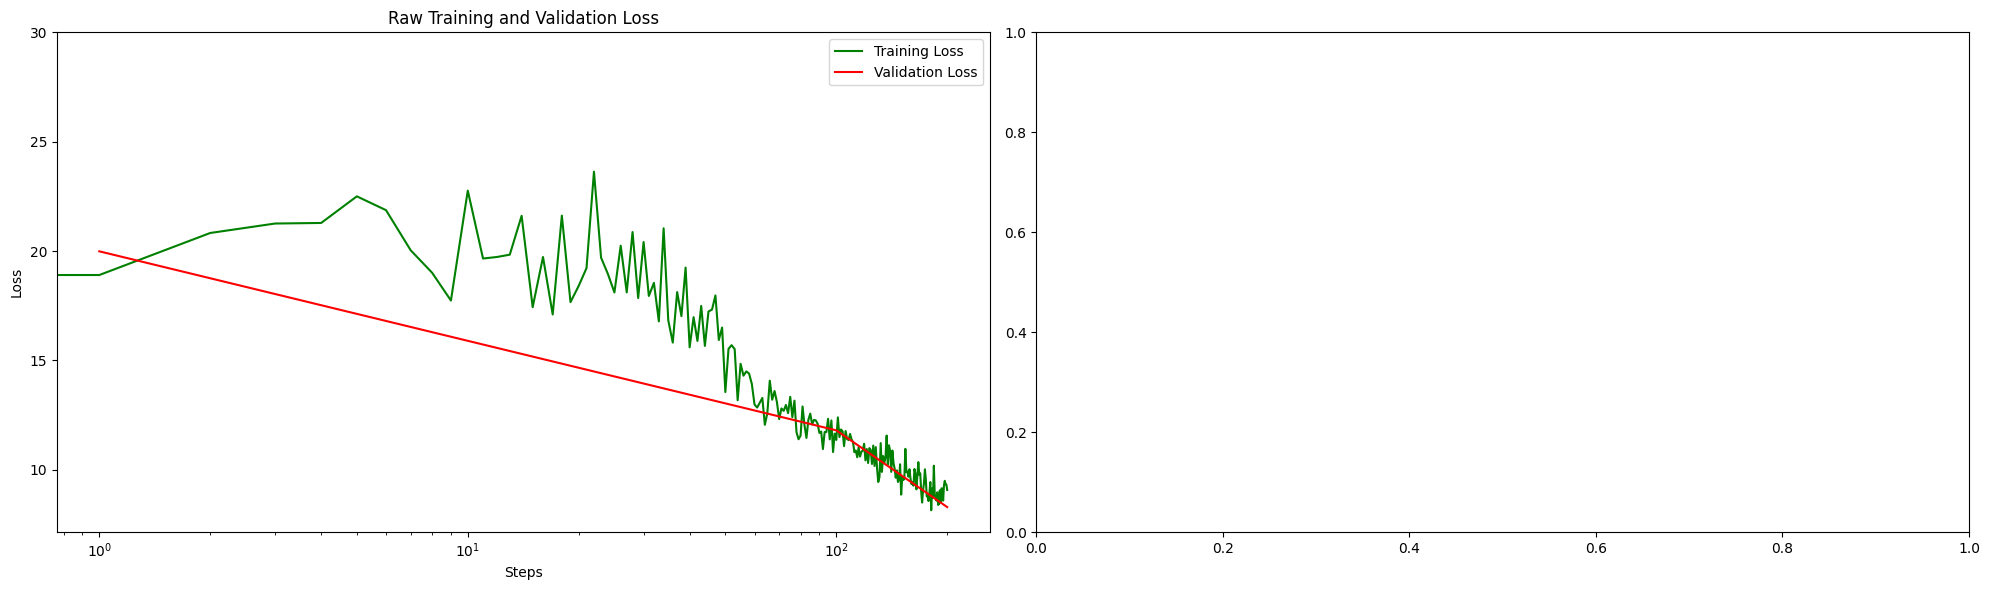

step: 285, lr: 0.0000285000 Loss: 6.8429, val_loss: 8.2935:   0%|          | 286/1000000 [02:19<95:45:04,  2.90it/s]  

: 

In [10]:
TrainConfig.learning_rate = 3e-4#4
TrainConfig.max_grad_norm = 1
TrainConfig.weight_decay = 1e-10
TrainConfig.gradient_accumulation_steps = 10
#torch.autograd.set_detect_anomaly(True)
#model.to(device)

#this is now a transformer model 
model,train_losses_dict = train(model, dataloader, dataloader_val,max_plot_val=30,warmup_frac=0.003)

In [24]:
# Calculate validation loss over 3 batches
val_loss = calculate_validation_loss(dataloader_val, model, num_batches=3)
print(f"Validation loss: {val_loss}")
# model

x_testing shape: torch.Size([30, 201, 120])
torch.Size([30, 200])
tensor(1.9216, device='cuda:0')


: 

# Get all nearby states to aid beam search

In [4]:
from envsAndScramble import Cube3
from sympy import primerange




# Get all states 5 moves away
if env.__class__.__name__ == 'AC_presentation':
    steps_away = min(TrainConfig.max_depth-3,4)
    non_unique_states_close_to_finish = get_states_n_moves_away_AC(steps_away)
    states_close_to_finish = np.array(np.unique(non_unique_states_close_to_finish,axis=0))
else:
    raise TypeError(f"env must be an instance of AC_presentation, actually is: {type(env).__name__}")

# Debug print to check the type of env
print(f"Type of env: {type(env)}")
print(f"Is instance of AC_presentation: {isinstance(env, AC_presentation)}")

print(f"Number of unique states {steps_away} moves away: {len(set(map(tuple, states_close_to_finish)))}")
print(f"Total number of states (including duplicates): {len(non_unique_states_close_to_finish)}")



# Convert states_4_moves to a set of hashed states for efficient lookup
hashed_states_close_to_finish = set(hash_state(state) for state in states_close_to_finish)
if len(hashed_states_close_to_finish)!=len(states_close_to_finish):
    print("Warning: hashed states collision! Change the prime.")
    print("hashed: ",len(hashed_states_close_to_finish))
    print("unhashed: ",len(states_close_to_finish))
hashed_states_close_to_finish_torch = torch.vmap(hash_vectors_torch)(torch.tensor(states_close_to_finish)).to(device)
torch_states_close_to_finish = torch.tensor(states_close_to_finish).to(device)

# Test the state checking functions with some example AC states
env.reset()
moves = [0,1]  # Apply a few AC moves
for move_index in moves:
    print(move_index)
    env.finger_ix_fast(move_index)
nearby_scrambled_state = env.state.copy()
print("nearby scrambled state:",nearby_scrambled_state)
print("Is the scrambled state in our list?", is_state_in_short_distance(nearby_scrambled_state))

# Generate a random AC state using scrambler with max length 5
random_state_generator = env.scrambler(20)  # Get generator with max length 5
for i in range(20):
    random_state,_ = next(random_state_generator)  # Get next random state
print("Random state:", random_state)
print("Is the random state in our list?", is_state_in_short_distance(random_state))

# Test with torch tensors
print("\nTesting with torch tensors:")
state_tensor = torch.tensor(nearby_scrambled_state, device=device)
print("Is the scrambled state in our list (torch)?", is_state_in_short_distance_torch(state_tensor))
print("Is the scrambled state in our list (actual)?", is_state_actually_in_list_torch(state_tensor))

random_state_tensor = torch.tensor(random_state, device=device)
print("Is the random state in our list (torch)?", is_state_in_short_distance_torch(random_state_tensor))
print("Is the random state in our list (actual)?", is_state_actually_in_list_torch(random_state_tensor))

# Test with a batch of states
batch_states = torch.stack([state_tensor, random_state_tensor, state_tensor])
print("Results for batch of states (torch):", is_state_in_short_distance_torch(batch_states))



Type of env: <class 'AC_env.AC_presentation'>
Is instance of AC_presentation: True
Number of unique states 4 moves away: 3645
Total number of states (including duplicates): 22621
hashed:  3511
unhashed:  3645
0
1
nearby scrambled state: [-2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Is the scrambled state in our list? True
Random state: [-2  1  2  1 -2 -1 -2  1  2  1  2 -1 -2 -1  2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 -2  1  2  1  2 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

# Plot the probabilities of moves over a trajectory

Testing model_pred predictions on sample states:
Loss:  tensor(1.6118, device='cuda:0')
tensor([[ 1,  2,  0,  ...,  0,  0,  0],
        [ 2,  1,  0,  ...,  0,  0,  0],
        [ 1,  2,  0,  ...,  0,  0,  0],
        ...,
        [-1, -2, -2,  ...,  0,  0,  0],
        [-1, -2, -2,  ..., -2,  1,  0],
        [-1, -2, -2,  ...,  0,  0,  0]], device='cuda:0')
tensor([[0.0022, 0.7530, 0.0022,  ..., 0.0355, 0.0000, 0.0602],
        [0.0008, 0.2727, 0.0017,  ..., 0.0183, 0.0000, 0.0133],
        [0.0024, 0.3003, 0.0031,  ..., 0.1288, 0.0000, 0.1796],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2024, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2023, 0.0000]],
       device='cuda:0', dtype=torch.float64)
Max probability: 0.7530
Min probability: 0.0000
Shape of predictions: torch.Size([200, 12])


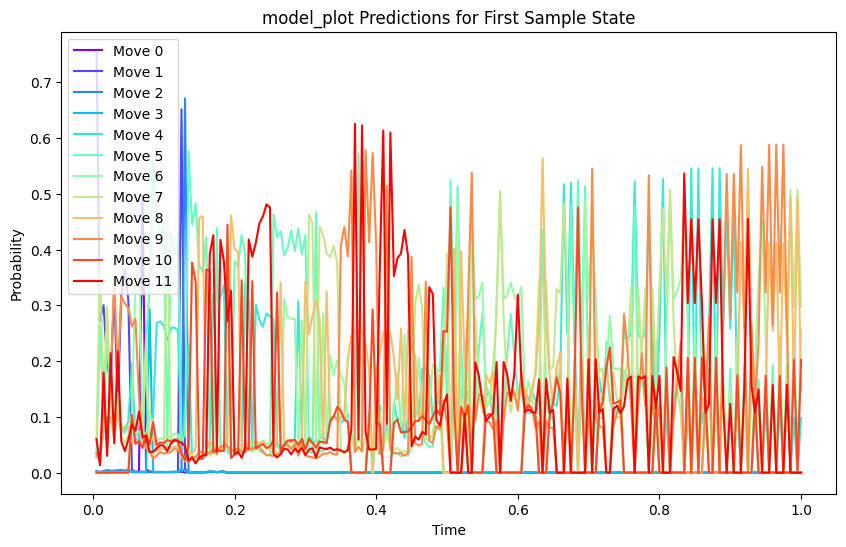

: 

In [27]:
# model2
# Test model2 predictions on some states
model_plot=model.to(device)
xtest = next(iter(dataloader_val))[0]
print("Testing model_pred predictions on sample states:")
#sample_states=saved[12:13].to(device)
sample_states=xtest[0:10].to(device)
num_steps = sample_states.shape[1]-1    
with torch.no_grad():
    model_plot.eval()
    batch_t = torch.linspace(0 +1/num_steps,1, steps=num_steps).to(device).unsqueeze(0).repeat(sample_states.shape[0], 1).to(device)#.unsqueeze(0).repeat(batch_x.shape[0], 1).to(device)
    loss = custom_loss_discrete(model_plot, sample_states, batch_t,None,env.goal)
print("Loss: ",loss)

sample_states.shape

# Create a sample batch of cube states
#sample_states = torch.randint(0, 6, (5, 54)).to(device)  # 5 random cube states
# sample_states=hi.to(device)

sample_states_test=sample_states[0,1:].to(device)
#sample_states_test=torch.tensor(test_scrambles[0]).to(device)


# Create time steps
t = torch.linspace(1/TrainConfig.max_depth,1,steps=TrainConfig.max_depth).to(device)#.unsqueeze(0).repeat(sample_states.shape[0], 1).to(device)
print(sample_states_test)
# Get model2 predictions
with torch.no_grad():
    model_plot.train()
    predictions = model_plot(sample_states_test, t)#.cpu().detach().numpy()
sample_states_test_gx = apply_all_moves_to_all_states_torch_jit(sample_states_test)
probabilities = get_probabilities_from_model_output(predictions,sample_states_test,sample_states_test_gx,env,weight_contraction=TrainConfig.weight_contraction,total_relator_weight=TrainConfig.total_relator_weight,double_weight=TrainConfig.double_weight)
#probabilities = predictions/predictions.sum(axis=-1, keepdims=True)
#print(predictions)
print(probabilities)
#`print("worst is: ", probabilities[5,1])
print(f"Max probability: {probabilities.max().item():.4f}")
print(f"Min probability: {probabilities.min().item():.4f}")
# Print shape of predictions
print(f"Shape of predictions: {probabilities.shape}")

# Plot predictions for the first state
plt.figure(figsize=(10, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, env.num_moves))
for i in range(env.num_moves):  # 12 possible moves
    plt.plot(t.cpu().numpy()+0*1/env.num_moves*0.1, probabilities[:, i].cpu().numpy(), label=f'Move {i}', color=colors[i])
    #plt.plot(t.cpu().numpy(), probabilities[:, i], label=f'Move {i}', color=colors[i])
plt.title("model_plot Predictions for First Sample State")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend()
plt.show()

# Print the most likely move at the beginning and end of the time sequence for each state
# print("\nMost likely moves:")
# for i in range(5):
#     start_move = torch.argmax(predictions[i, 0, :]).item()
#     end_move = torch.argmax(predictions[i, -1, :]).item()
#     print(f"State {i+1}: Start: Move {start_move}, End: Move {end_move}")


In [31]:
# Create K test scrambles by randomly sampling N moves each
K = 1000  # Number of scrambles to generate
N = TrainConfig.max_depth    # Number of moves per scramble
test_scrambles = [
    [random.choice(env.moves) for _ in range(N)] 
    for _ in range(K)
]

: 

In [98]:
dataloader_val = DataLoader(
        ScrambleGeneratorTORCH(max_depth=TrainConfig.max_depth,
                          total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth,
                          env=env,
                          seed=420033443,
                          batch_size=TrainConfig.batch_size_per_depth,
                          return_apply_all=return_apply_all,
                          weight_contraction=1,
                          total_relator_weight=0.1,
                          block_inverse_moves=TrainConfig.block_inverse_moves,
                          double_weight=100),  # Added a seed for reproducibility
        num_workers=min(6,os.cpu_count()),  # Set to 0 to avoid multiprocessing issues
        batch_size=None,
        prefetch_factor=2,
        persistent_workers=True,
        #pin_memory=True,
    )

: 

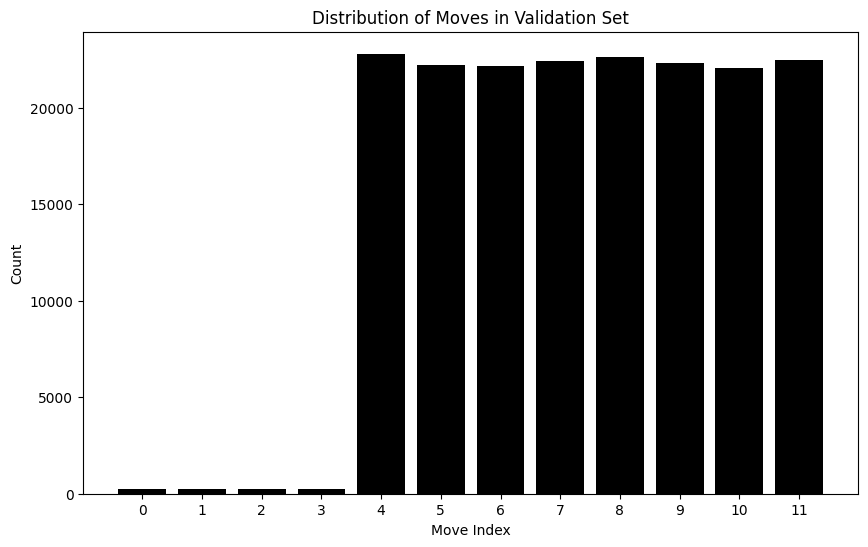

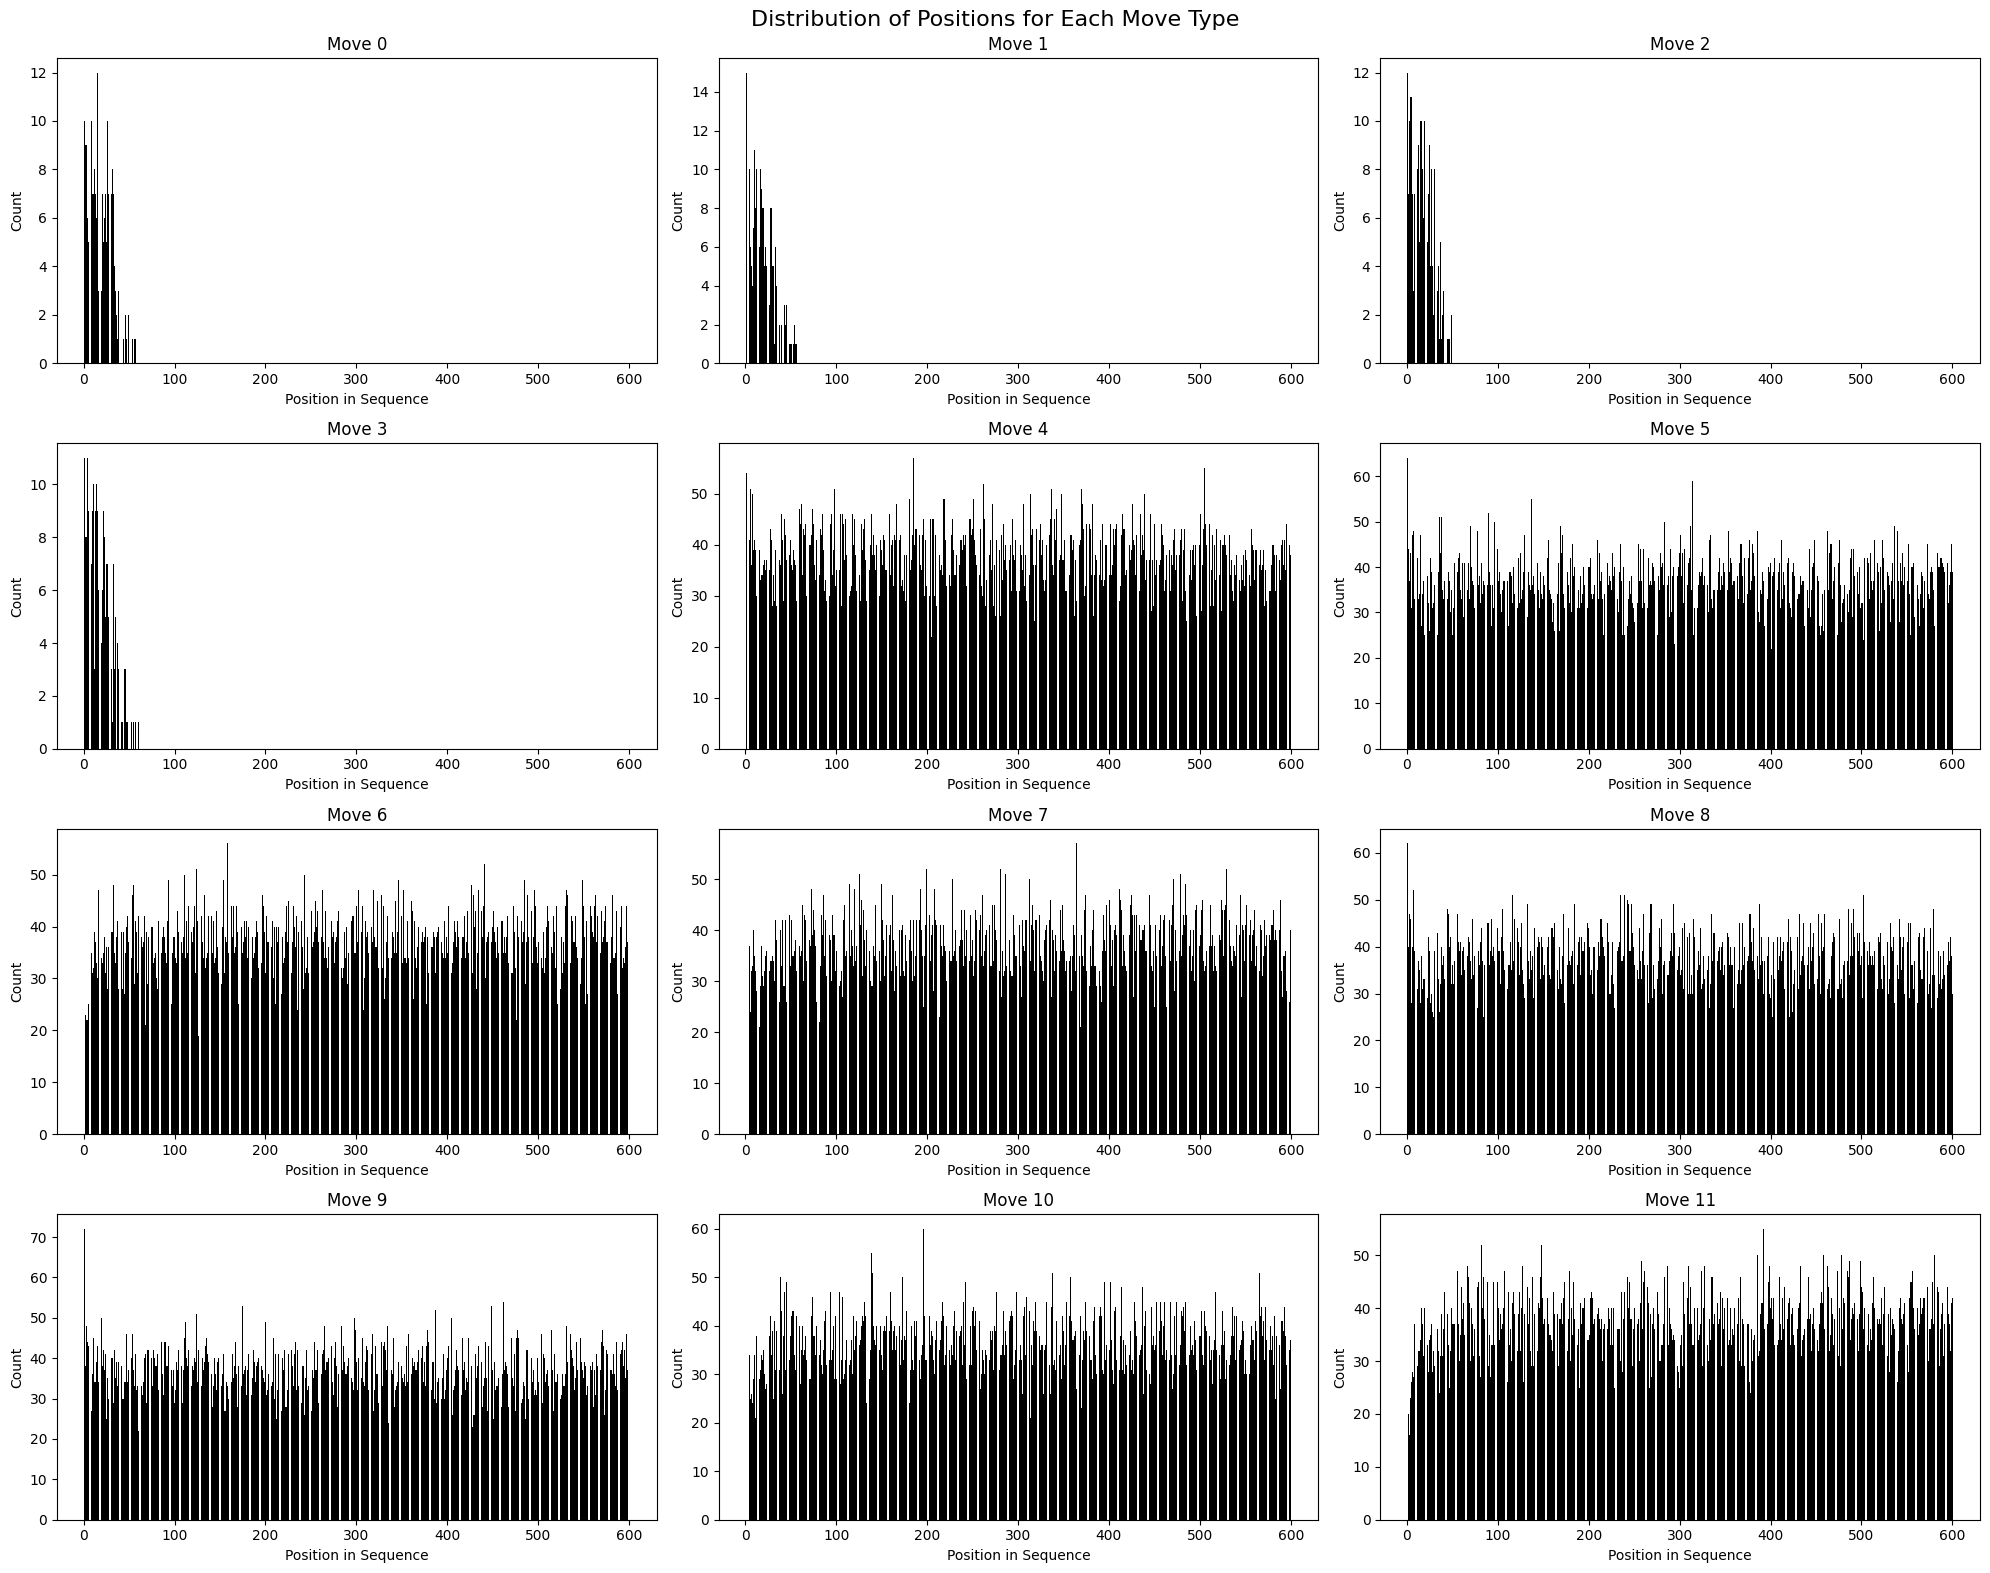

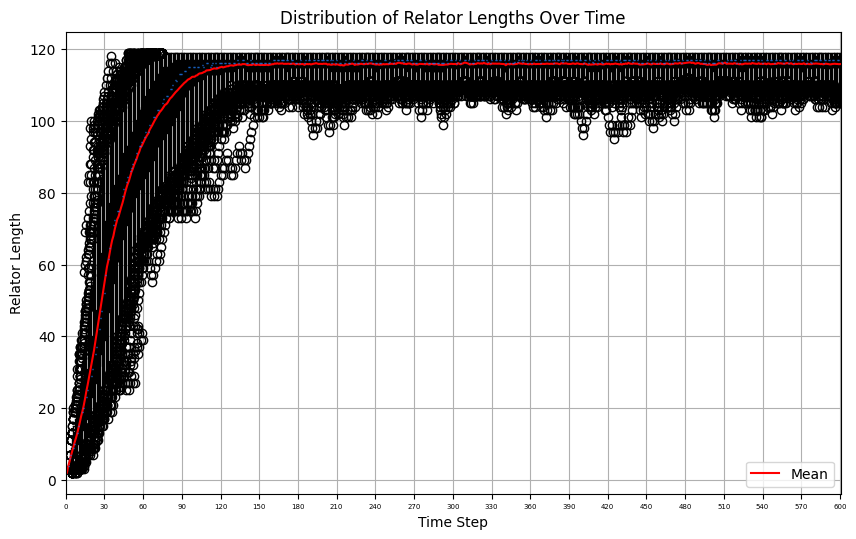

: 

In [99]:
env.reset()
iter_val= iter(dataloader_val)
moves = []
states = []
for i, (x, y,_) in enumerate(dataloader_val):
    if i >= 100: break  # Get 100 batches
    x, y, _ = next(iter_val)
    moves.extend(y.flatten().tolist())
    states.append(x)#x has shape (batch_size,max_depth,state_dim)

# Plot distribution of moves
plt.figure(figsize=(10,6))
plt.hist(moves, bins=range(13), align='left', rwidth=0.8)
plt.title('Distribution of Moves in Validation Set')
plt.xlabel('Move Index')
plt.ylabel('Count')
plt.xticks(range(12))

# Create a figure with subplots arranged in a 4x3 grid
plt.figure(figsize=(20,16))
plt.suptitle('Distribution of Positions for Each Move Type', fontsize=16)
# Convert moves to tensor and reshape once, outside the loop
moves_tensor = torch.tensor(moves).reshape(-1, TrainConfig.max_depth).flatten().tolist()

# For each move type (0-11)
for i in range(12):
    # Get positions where this move occurred
    move_positions = [(j % TrainConfig.max_depth) + 1 for j, move in enumerate(moves_tensor) if move == i]
    
    # Create subplot
    plt.subplot(4, 3, i+1)
    
    # Plot histogram of positions for this move
    plt.hist(move_positions, bins=range(1, TrainConfig.max_depth+2), align='left', rwidth=0.8)
    plt.title(f'Move {i}')
    plt.xlabel('Position in Sequence')
    plt.ylabel('Count')
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)


# Plot average relator length over time
states_tensor = torch.cat([s.to(dtype=torch.int64) for s in states], dim=0)  # Concatenate along batch dimension
lengths = []
for t in range(TrainConfig.max_depth):
    # Get states at time t
    states_t = states_tensor[:,t]
    # Count nonzero elements for each state
    nonzero = (states_t != 0).sum(dim=1)
    lengths.append(nonzero.tolist())

plt.figure(figsize=(10,6))
plt.boxplot(lengths, positions=range(1,TrainConfig.max_depth+1), whis=[5,95])
plt.plot(range(1,TrainConfig.max_depth+1), [sum(l)/len(l) for l in lengths], 'r-', label='Mean')
plt.title('Distribution of Relator Lengths Over Time')
plt.xlabel('Time Step')
plt.ylabel('Relator Length')
# Only show every 5th tick on x-axis for better readability
plt.xticks(range(0, TrainConfig.max_depth+1, TrainConfig.max_depth//20), [str(x) for x in range(0, TrainConfig.max_depth+1, TrainConfig.max_depth//20)],fontsize=5)

plt.legend()
plt.grid(True)


In [ ]:
AK_state_2=get_AKn_state(2,max_relator_length=env.max_relator_length)
AK_state_3=get_AKn_state(3,max_relator_length=env.max_relator_length)

In [43]:

env.reset()
successes = 0
n_to_run = 10
attempts=1
start_time = time.time()
total_solve_time = 0

uniform_random_scramble = False
env.reset()
#start_state = env.state# AK_state_2#env.state#AK_state_3#env.state
start_state = AK_state_2
scramble_lens_to_test = [100,200]#[10000,5000,3000,2000,1000,500,100]
results_all = []
force_generate_trajectory = True
if (not ('trajectory_from_AK_2' in locals())) or (len(trajectory_from_AK_2[0])-1)!=max(scramble_lens_to_test) or force_generate_trajectory:
    print("generating trajectory from: ",start_state)
    scrambler_from_state_generator = scrambler_torch(env, max(scramble_lens_to_test), batch_size=n_to_run, device='cpu',return_apply_all=False,weight_contraction=TrainConfig.weight_contraction,total_relator_weight=TrainConfig.total_relator_weight, start_state=start_state)
    trajectory_from_AK_2 = next(scrambler_from_state_generator)[0]

for len_scramble in scramble_lens_to_test:
    #len_scramble = 100
    if uniform_random_scramble:
        print('scrambling with uniform random scrambles, len_scramble: ',len_scramble)
        last_element_of_scramble = None
    elif not uniform_random_scramble:
        print('scrambling with proper scrambler, len_scramble: ',len_scramble)
        last_element_of_scramble = trajectory_from_AK_2[:,len_scramble-1]
    # #print(last_element_of_scramble.shape)
    
    for i in range(0,n_to_run):
        env.reset()
        
        if uniform_random_scramble:
            env.state = np.copy(start_state)
            env.apply_scramble(test_scrambles[i][0:len_scramble])
        else:
            env.state = last_element_of_scramble[i]
        #env.state = test_MS_AK3
        #env.apply_scramble(test_scrambles[i][0:10])
        initial_state_for_later = np.copy(env.state)
        length_true_solution = len(test_scrambles[i][0:len_scramble]) if uniform_random_scramble else None
        
        solve_start = time.time()
        #success, result, path,attempt = beam_search(env, model5,max_depth=TrainConfig.max_depth, check_short_distance=True, beam_width=1000,attempts=attempts)
        success, result, path,attempt = beam_search_fast(env, model,max_depth=TrainConfig.max_depth, check_short_distance=True, beam_width=1000,attempts=attempts,expensive_pick_best=True)
        solve_time = time.time() - solve_start
        total_solve_time += solve_time
        
        if success:
            successes += 1
            results_all.append({
                'success': True,
                'length': len(path)+steps_away,
                'true_length': length_true_solution,
                'attempt': attempt+1,
                'solve_time': solve_time,
                'num_nodes': result['num_nodes_generated'],
                'initial_state': initial_state_for_later,
                'scramble': test_scrambles[i][0:len_scramble],
                'result': result
            })
        if success:
            print(f"Case {i}: Success, length {len(path)+steps_away} vs {length_true_solution} attempt {attempt+1} (took {solve_time:.2f}s), num_nodes: {result['num_nodes_generated']}, initial state: {env.state}")
        else:
            print(f"Case {i}: Failure on attempt {attempt+1} (took {solve_time:.2f}s), num_nodes: {result['num_nodes_generated']}")# initial state: {env.state},

total_time = time.time() - start_time
print(f"\nSuccessfully solved {successes} out of {n_to_run} cases ({(successes/n_to_run)*100:.1f}%)")
print(f"Total time: {total_time:.2f}s")

print(f"Average time per solve: {total_solve_time/n_to_run:.2f}s")


generating trajectory from:  [ 1  1 -2 -2 -2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1  2  1 -2 -1 -2  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
scrambling with proper scrambler, len_scramble:  100
using initial state of env


/tmp/ipykernel_3326121/750000560.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  candidate_states[0,:] = torch.tensor(env.state,device=device,dtype=torch.int64)


KeyboardInterrupt: 

: 

In [ ]:
env.reset()
successes = 0
n_to_run = 3
attempts=1
start_time = time.time()
total_solve_time = 0


for j in list(range(10,1000,100))[::-1]:
    print(f"\nNumber of scrambles: {j}")
    for i in range(0,n_to_run):
        env.reset()
        env.state = AK_state_2
        env.apply_scramble(test_scrambles[i][0:j])
        length_true_solution = len(test_scrambles[i])

        solve_start = time.time()
        #success, result, path,attempt = beam_search(env, model5,max_depth=TrainConfig.max_depth, check_short_distance=True, beam_width=1000,attempts=attempts)
        success, result, path,attempt = beam_search_fast(env, model,max_depth=TrainConfig.max_depth, check_short_distance=True, beam_width=1000,attempts=attempts)
        solve_time = time.time() - solve_start
        total_solve_time += solve_time

        if success:
            successes += 1
        if success:
            print(f"Case {i}: Success, length {len(path)+steps_away} vs {length_true_solution} attempt {attempt+1} (took {solve_time:.2f}s),initial state: {env.state}")
        elif i%10==0:
            print(f"Length {j} Case {i}: Failure on attempt {attempt+1} (took {solve_time:.2f}s), initial state: {env.state}")

total_time = time.time() - start_time
print(f"\nSuccessfully solved {successes} out of {n_to_run} cases ({(successes/n_to_run)*100:.1f}%)")
print(f"Total time: {total_time:.2f}s")

print(f"Average time per solve: {total_solve_time/n_to_run:.2f}s")

using state of env
Length 125 Case 0: Failure on attempt 1 (took 4.91s), initial state: [ 1 -2 -2  1 -2  1  1 -2  1  2  1 -2 -1 -1 -1  2  2  1  2  1 -2 -1 -1 -1
  2 -1  2  2 -1  0 -2  1 -2 -2 -1 -1 -2  1  2 -1  2  1  2  1 -2 -1 -1 -1
  2  1 -2 -1  2  1  1  2  2 -1  2  0]
using state of env
using state of env
using state of env
using state of env


KeyboardInterrupt: 

: 

In [ ]:
def get_random_scramble_of_state_torch(state, scramble_length):
    current_state = torch.tensor(state, device='cpu',dtype=torch.int64)
    moves=torch.zeros((scramble_length,),device='cpu',dtype=torch.long)
    for i in range(scramble_length):
        last_state = current_state.clone()
        moves_temp = list(range(env.num_moves))
        while torch.equal(current_state,last_state):
            move = random.choice(moves_temp)
            current_state = finger_ix_fast_vec_torch(current_state.unsqueeze(0), move).squeeze(0)
            moves_temp.remove(move)
        moves[i] = move
    return current_state,moves

for n_scrambles in range(1,40,3):
    #Generate 1000 random scrambles and test them
    n_candidates = 1000
    n_AK_scrambles = n_scrambles # Length of each scramble
    candidates = torch.zeros((n_candidates,env.state.size),device=device,dtype=torch.int64)
    scrambles = torch.zeros((n_candidates,n_AK_scrambles),device=device,dtype=torch.int64)


    def apply_scramble_torch(state, scramble):
        for move in scramble:
            state = finger_ix_fast_vec_torch(state.unsqueeze(0), move).squeeze(0)
        return state
    # Start from AK_state_2 and apply random scrambles
    for i in range(n_candidates):
        #state_scramble =torch.tensor(AK_state_2,device=device,dtype=torch.int64)  # Reset to initial state
        #scramble = torch.randint(0, env.num_moves, (n_AK_scrambles,), device=env.state.device)
        #state_out=apply_scramble_torch(state_scramble,scramble)
        env.state = AK_state_3
        state,scramble = get_random_scramble_of_state_torch(env.state,n_AK_scrambles)
        candidates[i,:] = state
        scrambles[i,:] = scramble

    print("\nStarting beam search ")

    # Try to solve each candidate state
    successes = 0
    success, result, path, attempt = beam_search_fast(
        env, 
        model,
        #max_depth=TrainConfig.max_depth, 
        max_depth=40,
        check_short_distance=True, 
        beam_width=100000,
        attempts=1,
        many_initial_states=candidates,
        expensive_pick_best=True
    )

    if success:
        print(f"Solved candidate: num_nodes: {result['num_nodes_generated']}")
        break
    else:
        print(f"Failed to solve candidate, num_nodes: {result['num_nodes_generated']}")


In [ ]:
AK_state_2=get_AKn_state(2,max_relator_length=env.max_relator_length)
env.state=AK_state_2
beam_search_fast(env, model, beam_width=10000, max_depth=TrainConfig.max_depth, check_short_distance=True, skip_redundant_moves=True,attempts=1,start_step=10)

(False,
 {'solution': None, 'num_nodes_generated': 261841, 'time': 1.944532871246338},
 None,
 0)

: 

In [ ]:
model_to_use = model
result_ours = {
    "solution": [],
    "num_nodes_generated": [],
    "time": [],
    "solution_lengths": []
}

for i, scramble in enumerate(tqdm(test_scrambles[0:20], position=0)):
    # reset and scramble
    env.reset()
    env.apply_scramble(scramble[0:])
    optimal_length = len(scramble)
    
    # solve
    success, result, path, attempt = beam_search_fast(env, model_to_use, check_short_distance=True, beam_width=3, attempts=1)
    
    if success:
        solve_length = len(path) + steps_away  # Add 5 for short distance moves
        print(f"\nScramble {i}: Success - Length {solve_length} vs Optimal {optimal_length} on attempt {attempt+1}")
        result_ours["solution"].append(path)
        result_ours["num_nodes_generated"].append(result["num_nodes_generated"])
        result_ours["time"].append(result["time"])
        result_ours["solution_lengths"].append(solve_length)
    else:
        print(f"\nScramble {i}: Failed to solve on attempt {attempt+1}")
        result_ours["solution"].append(None)
        result_ours["num_nodes_generated"].append(None)
        result_ours["time"].append(None)
        result_ours["solution_lengths"].append(None)

# Calculate statistics only on successful solves
successful_lengths = [l for l in result_ours["solution_lengths"] if l is not None]
successful_solves = len(successful_lengths)
total_attempts = len(result_ours["solution"])

f"Successfully solved {successful_solves} cases out of {total_attempts}, average solution length: {np.mean(successful_lengths) if successful_lengths else 0}"

In [70]:
from importlib import reload
import NN_models
NN_models = reload(NN_models)


# Train a PPO agent to improve the forward scrambling process

In [8]:


env = AC_presentation(max_relator_length=60)
# save_policy = agent.policy
# save_value = agent.value
agent = PPOAgent(state_size=env.state_dim,
                 n_actions=env.num_moves,
                 hidden_dim=512,
                 entropy_coef=0.05,
                 value_coef=0.001,
                 epsilon=0.2,#default 0.2
                 lr=0.003,
                 gamma=0.99
                 )
# agent.policy = save_policy
# agent.value = save_value
# agent2.policy = agent.policy
# agent2.value = agent.value

# Train the agent with the vectorized routine
agent.train(env=env,
            initial_state=torch.tensor(env.reset(), dtype=torch.long,device=torch.device("cuda")),
            n_episodes=100000,
            scramble_length=TrainConfig.max_depth,
            batch_size=3000,
            n_epochs_per_batch=20)

Final Loss: 272.1707,avg return: -482.0041,  Policy Loss: -0.0018, Value Loss: 272252.9375, Entropy: 1.6072, collect: 15.90s, update: 1.27s:   0%|          | 3/100000 [00:51<475:06:40, 17.10s/it]

: 

In [11]:
print("hi")

hi


In [12]:
import numpy as np
import torch
import zlib
from typing import Union, List

#-np.float64(2.6928250806439102)

# def kolmogorov_complexity_of_state(arr):
    

# return np.array([approximate_kolmogorov_complexity_array(row) for row in arr])
#print(env.goal)
print(approximate_kolmogorov_complexity_array(env.goal,baseline=2.44892264161952))
print(approximate_kolmogorov_complexity_array(np.random.randint(-2,2,size=(2000)),baseline=2.44892264161952))

def list_approximate_kolmogorov_complexity_array(arrs):
    return np.array([approximate_kolmogorov_complexity_array(arr,baseline=2.44892264161952) for arr in arrs])

# list_approximate_kolmogorov_complexity_array(traj2[0][4])
#traj2[0].shape
#print(traj2[0][4][-1])
#print(traj2[0][6][-1])


-0.36376068449828836
54.51425085467087


In [13]:
#generate a set of trajectories

agent.policy.to('cpu')
def useful_fwd_diffusion(states):
    #learned_policy = torch.ones((states.shape[0],12))/12
    learned_policy = agent.policy(states)
    good_moves_mask = mask_impossible_moves(states,env)
    learned_policy = learned_policy*good_moves_mask
    learned_policy = learned_policy/learned_policy.sum(dim=-1,keepdims=True)
    return learned_policy
def random_fwd_diffusion(states):
    #learned_policy = torch.rand((states.shape[0],12))/12
    learned_policy = torch.ones((states.shape[0],12))/12
    good_moves_mask = mask_impossible_moves(states,env)
    learned_policy = learned_policy*good_moves_mask
    learned_policy = learned_policy/learned_policy.sum(dim=-1,keepdims=True)
    return learned_policy
    

traj = generate_trajectory_torch_batch(batch_size=100,scramble_length=TrainConfig.max_depth,env=env,device=torch.device("cpu"),start_state=torch.tensor(env.reset(), dtype=torch.long),return_apply_all=False,fwd_diffusion_function=useful_fwd_diffusion)
traj2 = generate_trajectory_torch_batch(batch_size=100,scramble_length=TrainConfig.max_depth,env=env,device=torch.device("cpu"),start_state=torch.tensor(env.reset(), dtype=torch.long),return_apply_all=False,fwd_diffusion_function=random_fwd_diffusion)


Total number of moves 0-3: 410


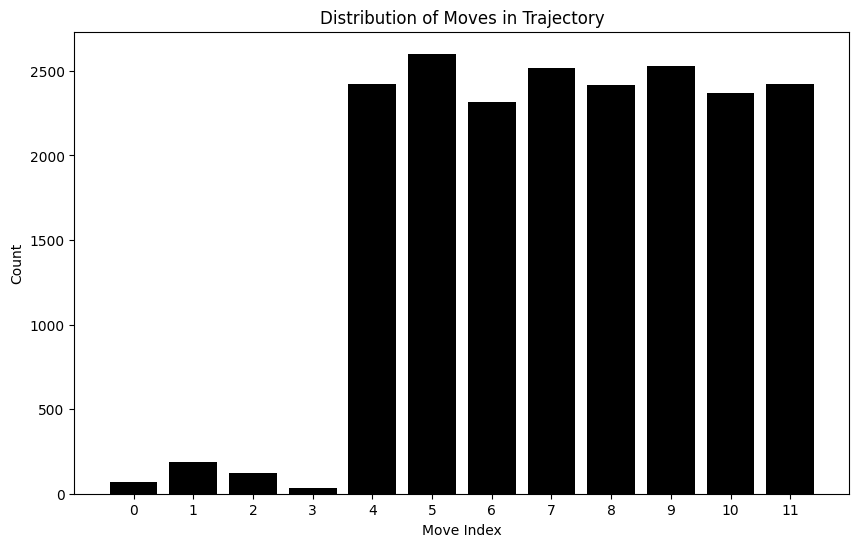

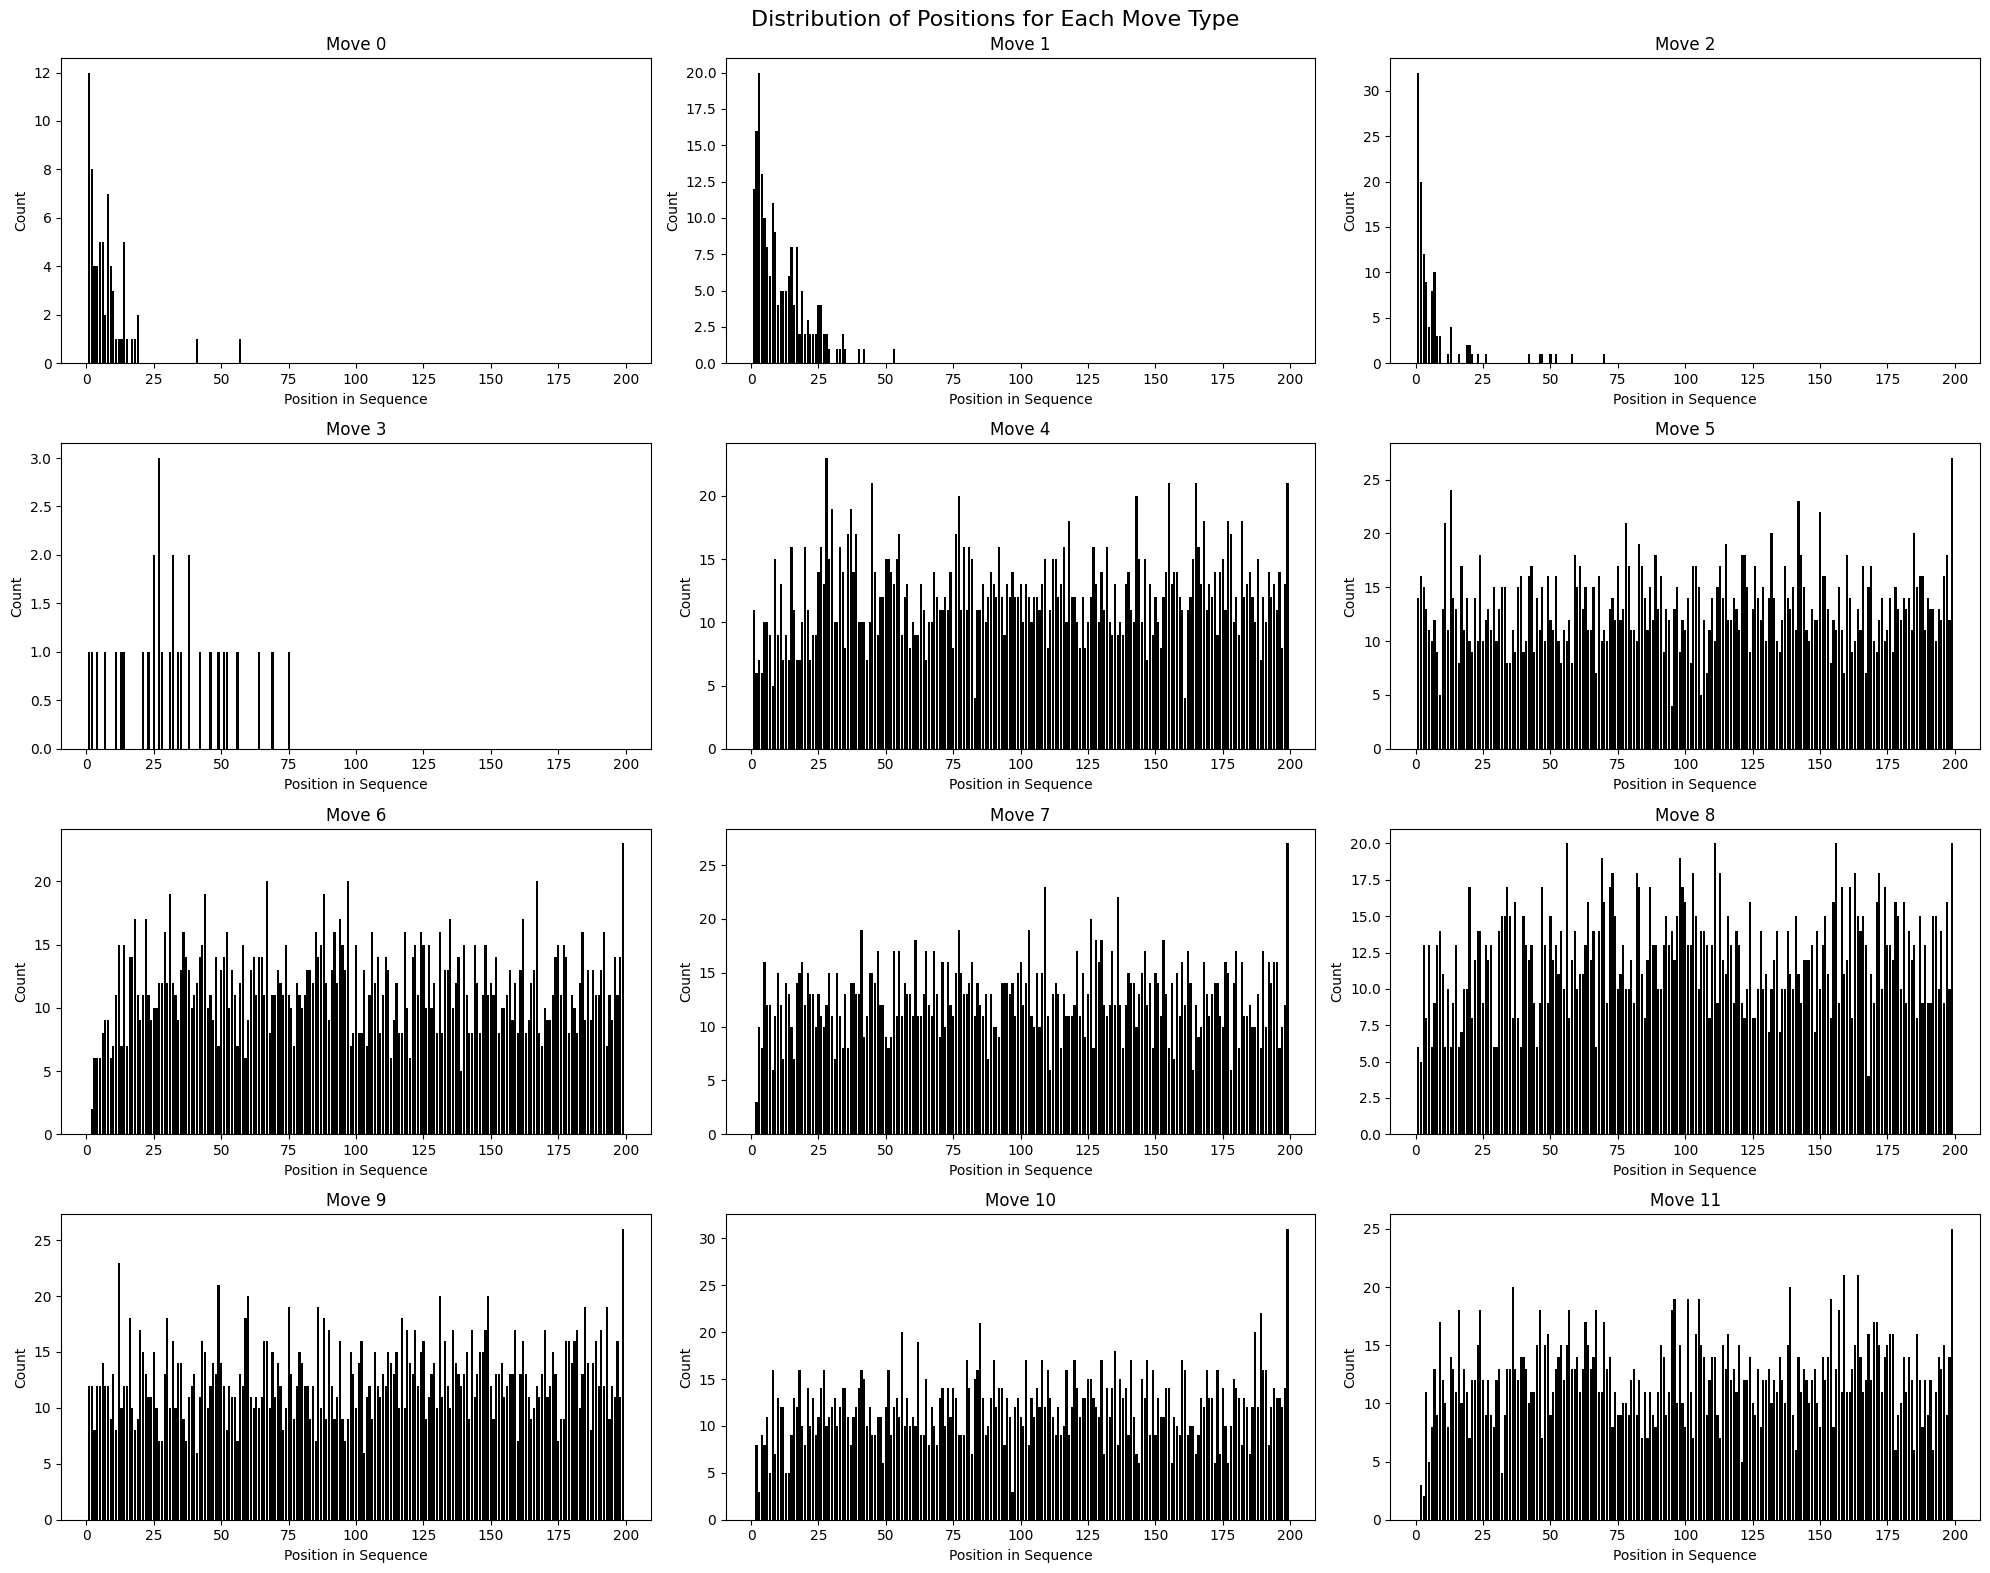

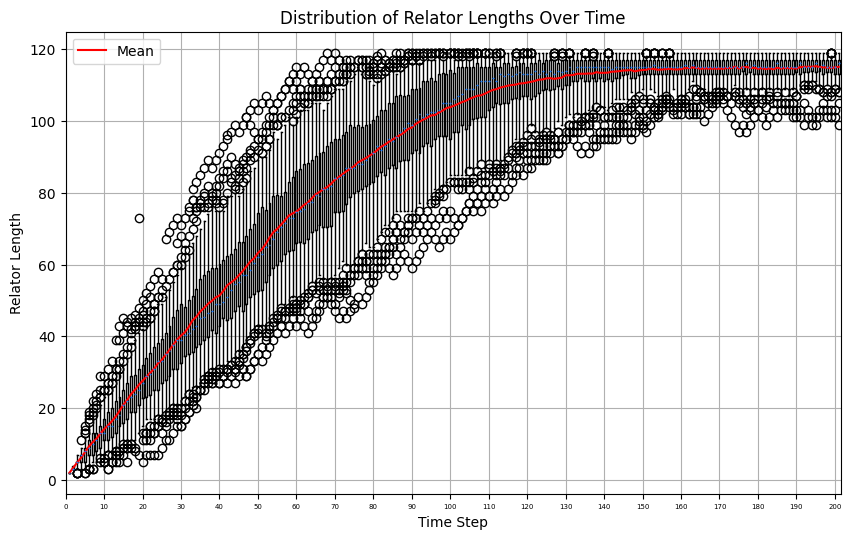

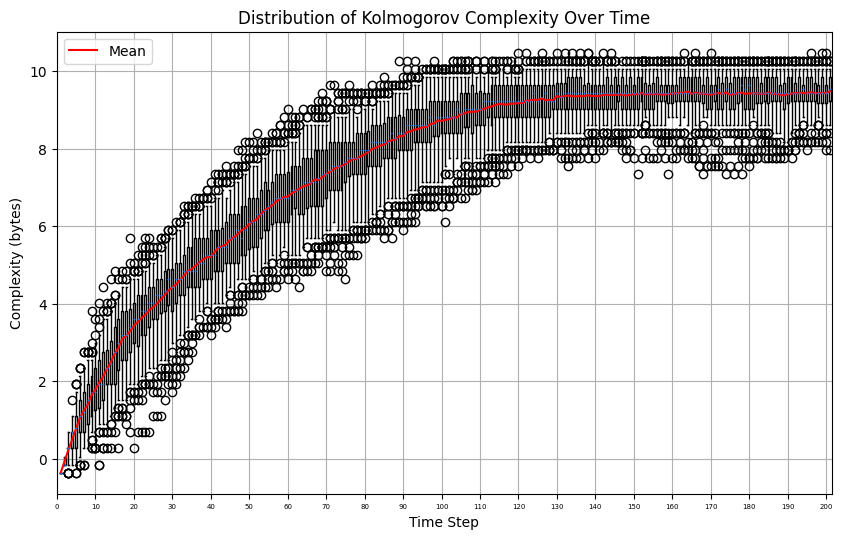

In [14]:
# Extract moves from trajectory
traj_print = traj

moves = traj_print[1] # Shape: [batch, time]
num_states = traj_print[0].shape[1] # Number of states (including initial)
num_moves = num_states - 1 # Number of moves is one less than states

# Plot distribution of moves
plt.figure(figsize=(10,6))
plt.hist(moves.flatten(), bins=range(13), align='left', rwidth=0.8)
plt.title('Distribution of Moves in Trajectory')
plt.xlabel('Move Index')
plt.ylabel('Count')
plt.xticks(range(12))

# Create a figure with subplots arranged in a 4x3 grid
plt.figure(figsize=(20,16))
plt.suptitle('Distribution of Positions for Each Move Type', fontsize=16)

# For each move type (0-11)
for i in range(12):
    # Get positions where this move occurred
    move_mask = (moves == i)
    move_positions = torch.nonzero(move_mask)[:,1] + 1 # Add 1 since moves start at position 1
    
    # Create subplot
    plt.subplot(4, 3, i+1)
    
    # Plot histogram of positions for this move
    plt.hist(move_positions.numpy(), bins=range(1, num_moves+1), align='left', rwidth=0.8)
    plt.title(f'Move {i}')
    plt.xlabel('Position in Sequence')
    plt.ylabel('Count')
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Plot average relator length over time
states_tensor = traj_print[0]  # Already a tensor
lengths = []
for t in range(num_states):
    # Get states at time t
    states_t = states_tensor[:,t]
    # Count nonzero elements for each state
    nonzero = (states_t != 0).sum(dim=1)
    lengths.append(nonzero.tolist())

plt.figure(figsize=(10,6))
plt.boxplot(lengths, positions=range(1,num_states+1), whis=[5,95])
plt.plot(range(1,num_states+1), [sum(l)/len(l) for l in lengths], 'r-', label='Mean')
plt.title('Distribution of Relator Lengths Over Time')
plt.xlabel('Time Step')
plt.ylabel('Relator Length')
# Only show every 10th tick on x-axis for better readability
plt.xticks(range(0, num_states+1, 10), [str(x) for x in range(0, num_states+1, 10)], fontsize=5)

plt.legend()
plt.grid(True)

# Count total number of moves 0-3
num_moves_0_3 = torch.sum((moves >= 0) & (moves <= 3)).item()
print(f"Total number of moves 0-3: {num_moves_0_3}")

# Count unique states at each timestep
[torch.unique(states_tensor[:,i], dim=0).shape[0] for i in range(states_tensor.shape[1])]

# Plot Kolmogorov complexity over time
plt.figure(figsize=(10,6))

# Get states tensor from traj[0]
states = traj_print[0]  # Shape: [batch, time, state]

# Calculate Kolmogorov complexity for each state at each timestep
complexities = []
for t in range(states.shape[1]):  # For each timestep
    time_complexities = []
    for b in range(states.shape[0]):  # For each batch element
        # Convert state to bytes for compression
        complexity = approximate_kolmogorov_complexity_array(states[b,t].cpu().numpy())
        time_complexities.append(complexity)
    complexities.append(time_complexities)

# Create boxplot
plt.boxplot(complexities, positions=range(1,states.shape[1]+1), whis=[5,95])

# Add mean line
means = [sum(c)/len(c) for c in complexities]
plt.plot(range(1,states.shape[1]+1), means, 'r-', label='Mean')

plt.title('Distribution of Kolmogorov Complexity Over Time')
plt.xlabel('Time Step') 
plt.ylabel('Complexity (bytes)')
plt.xticks(range(0, states.shape[1], 10), [str(x) for x in range(0, states.shape[1], 10)], fontsize=5)
plt.legend()
plt.grid(True)


In [71]:
# plt.hist(moves[4].flatten(), bins=range(13), align='left', rwidth=0.8)

Total number of moves 0-3: 775


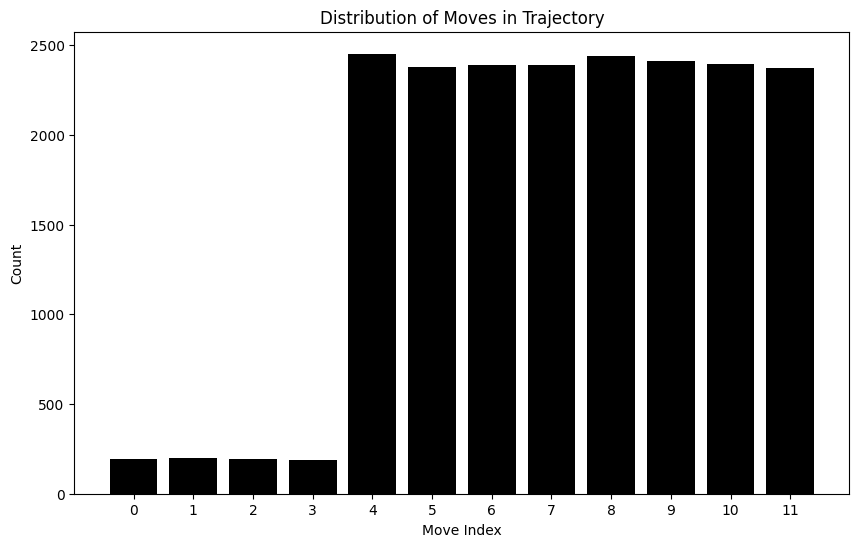

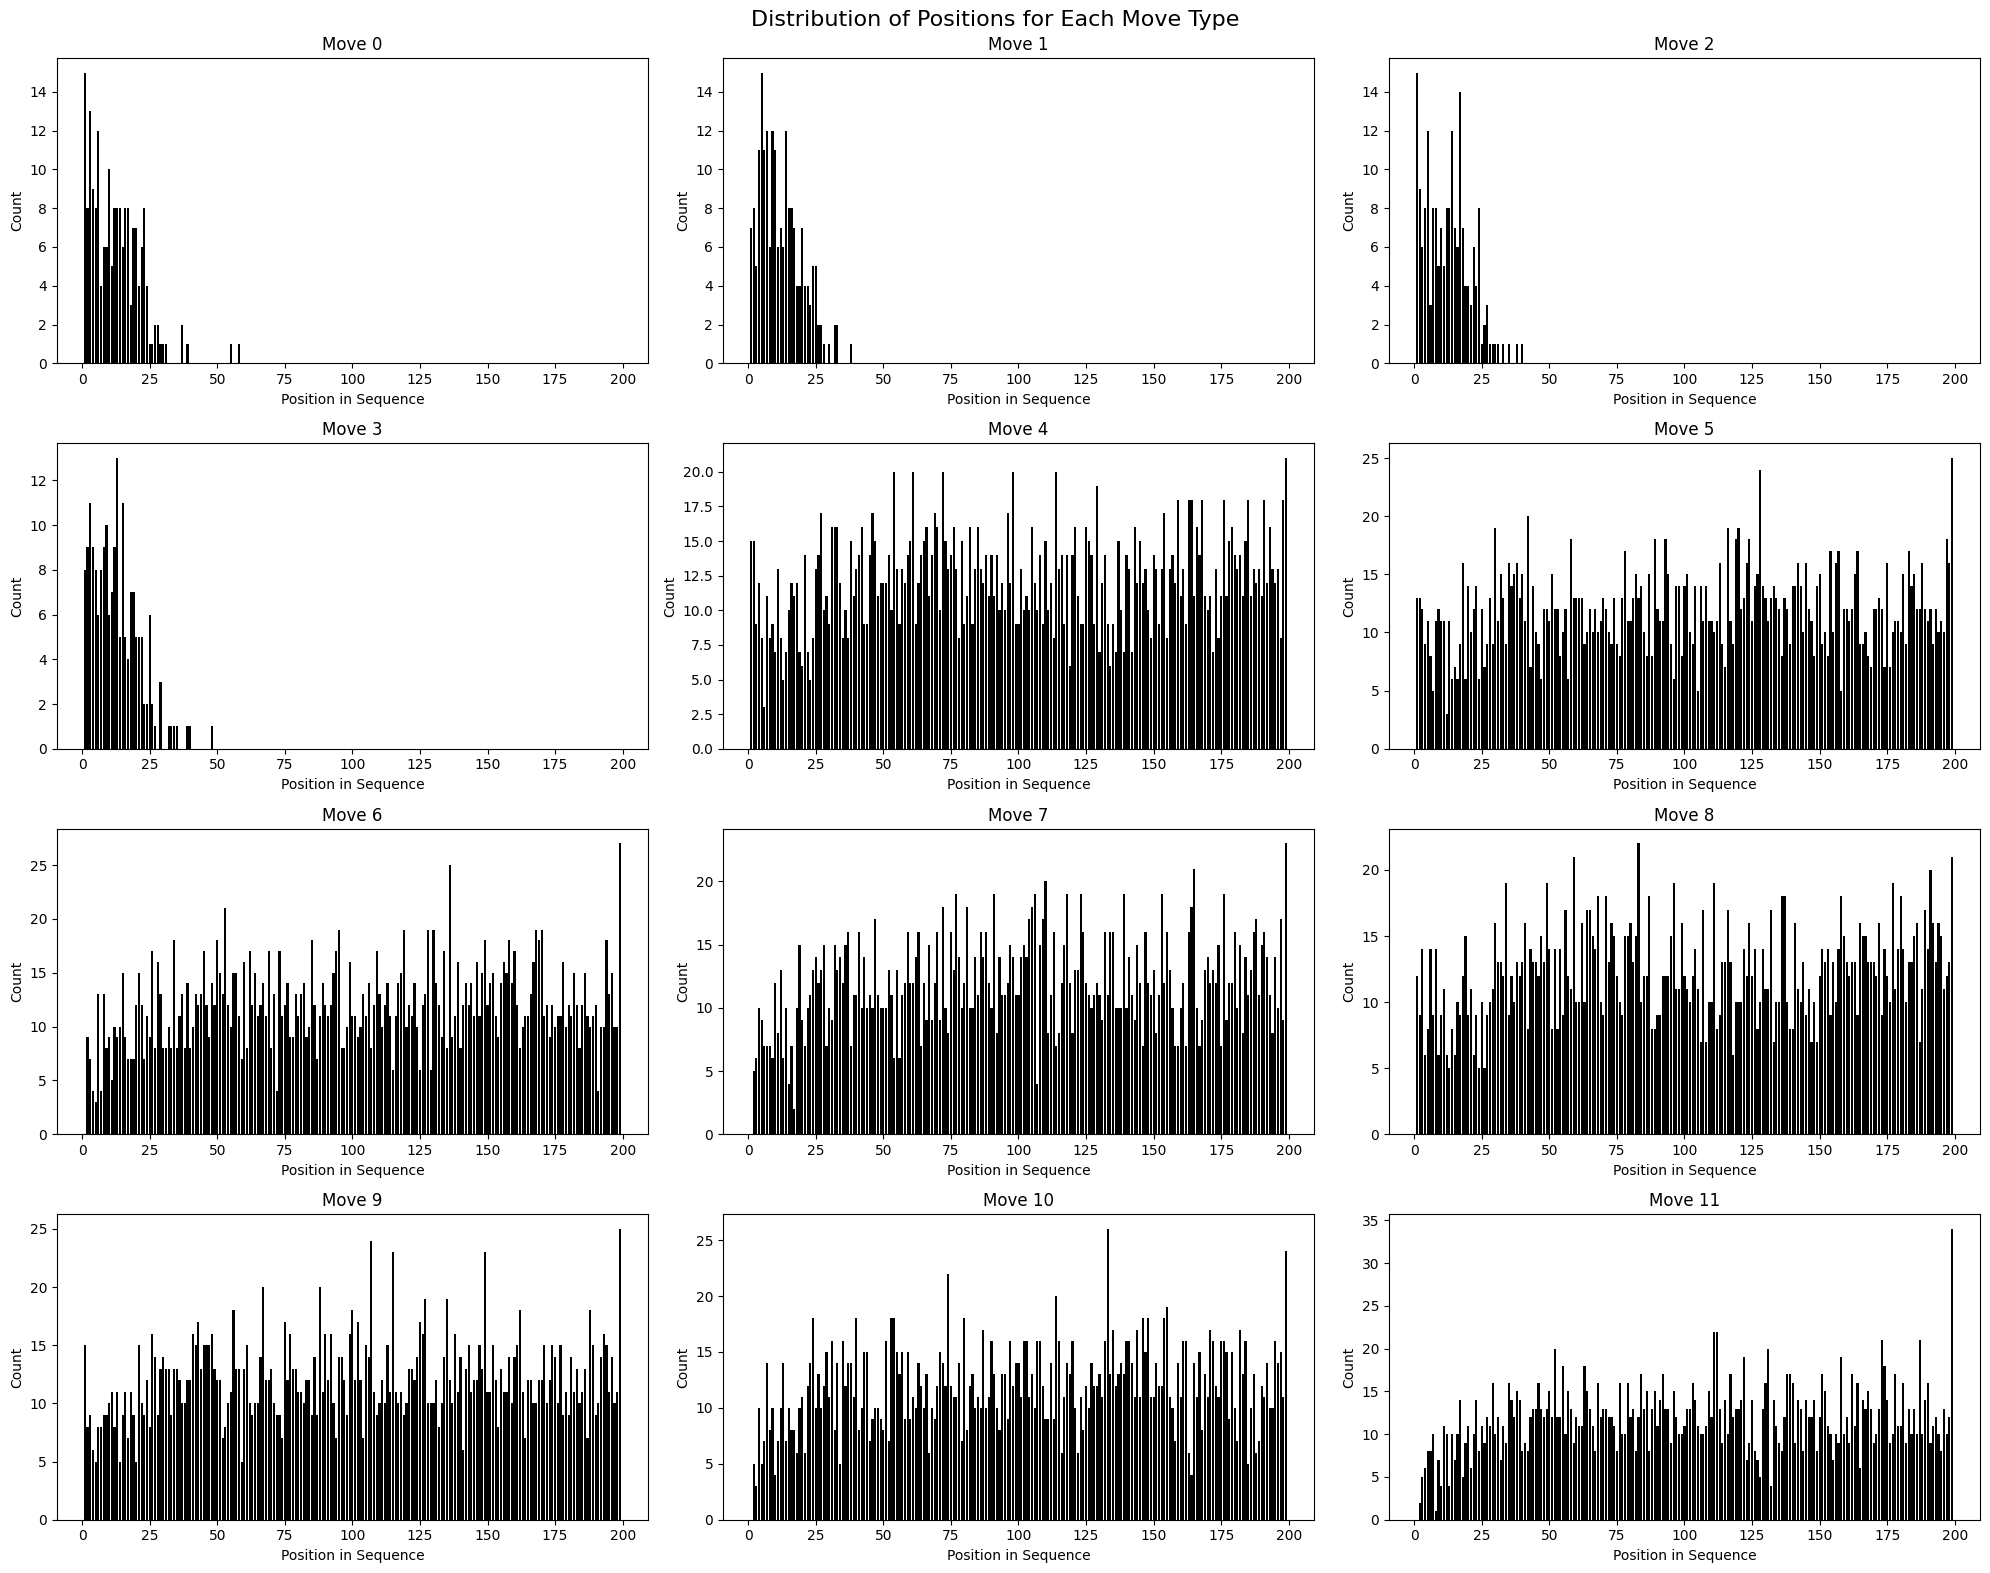

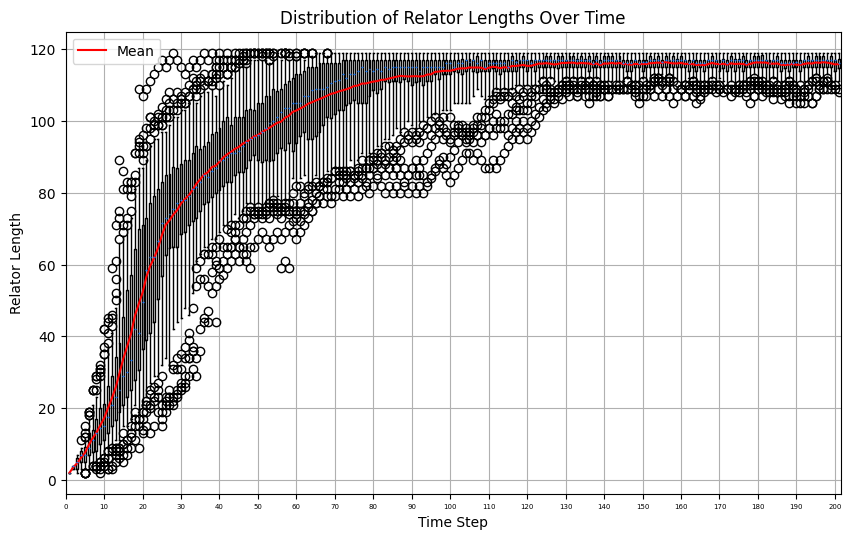

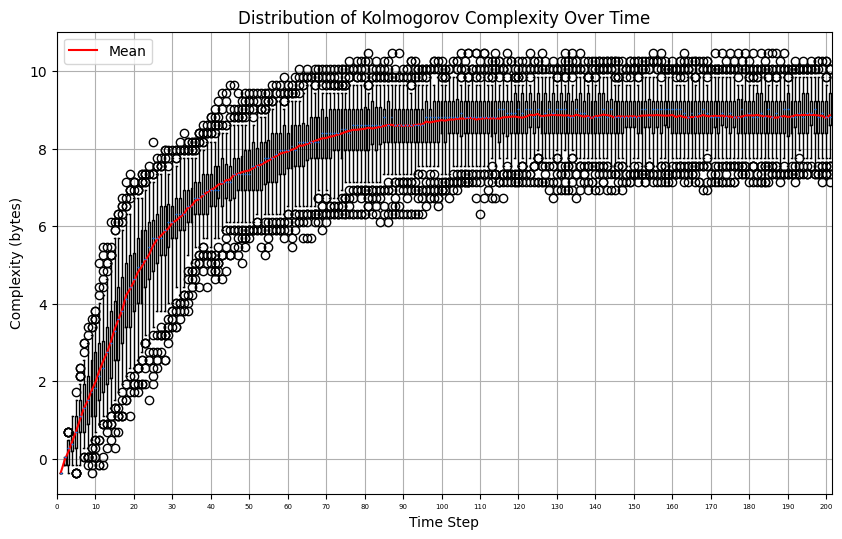

In [15]:
# Extract moves from trajectory
traj_print = traj2

moves = traj_print[1] # Shape: [batch, time]
num_states = traj_print[0].shape[1] # Number of states (including initial)
num_moves = num_states - 1 # Number of moves is one less than states

# Plot distribution of moves
plt.figure(figsize=(10,6))
plt.hist(moves.flatten(), bins=range(13), align='left', rwidth=0.8)
plt.title('Distribution of Moves in Trajectory')
plt.xlabel('Move Index')
plt.ylabel('Count')
plt.xticks(range(12))

# Create a figure with subplots arranged in a 4x3 grid
plt.figure(figsize=(20,16))
plt.suptitle('Distribution of Positions for Each Move Type', fontsize=16)

# For each move type (0-11)
for i in range(12):
    # Get positions where this move occurred
    move_mask = (moves == i)
    move_positions = torch.nonzero(move_mask)[:,1] + 1 # Add 1 since moves start at position 1
    
    # Create subplot
    plt.subplot(4, 3, i+1)
    
    # Plot histogram of positions for this move
    plt.hist(move_positions.numpy(), bins=range(1, num_moves+1), align='left', rwidth=0.8)
    plt.title(f'Move {i}')
    plt.xlabel('Position in Sequence')
    plt.ylabel('Count')
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Plot average relator length over time
states_tensor = traj_print[0]  # Already a tensor
lengths = []
for t in range(num_states):
    # Get states at time t
    states_t = states_tensor[:,t]
    # Count nonzero elements for each state
    nonzero = (states_t != 0).sum(dim=1)
    lengths.append(nonzero.tolist())

plt.figure(figsize=(10,6))
plt.boxplot(lengths, positions=range(1,num_states+1), whis=[5,95])
plt.plot(range(1,num_states+1), [sum(l)/len(l) for l in lengths], 'r-', label='Mean')
plt.title('Distribution of Relator Lengths Over Time')
plt.xlabel('Time Step')
plt.ylabel('Relator Length')
# Only show every 10th tick on x-axis for better readability
plt.xticks(range(0, num_states+1, 10), [str(x) for x in range(0, num_states+1, 10)], fontsize=5)

plt.legend()
plt.grid(True)

# Count total number of moves 0-3
num_moves_0_3 = torch.sum((moves >= 0) & (moves <= 3)).item()
print(f"Total number of moves 0-3: {num_moves_0_3}")

# Count unique states at each timestep
[torch.unique(states_tensor[:,i], dim=0).shape[0] for i in range(states_tensor.shape[1])]

# Plot Kolmogorov complexity over time
plt.figure(figsize=(10,6))

# Get states tensor from traj[0]
states = traj_print[0]  # Shape: [batch, time, state]

# Calculate Kolmogorov complexity for each state at each timestep
complexities = []
for t in range(states.shape[1]):  # For each timestep
    time_complexities = []
    for b in range(states.shape[0]):  # For each batch element
        # Convert state to bytes for compression
        complexity = approximate_kolmogorov_complexity_array(states[b,t].cpu().numpy())
        time_complexities.append(complexity)
    complexities.append(time_complexities)

# Create boxplot
plt.boxplot(complexities, positions=range(1,states.shape[1]+1), whis=[5,95])

# Add mean line
means = [sum(c)/len(c) for c in complexities]
plt.plot(range(1,states.shape[1]+1), means, 'r-', label='Mean')

plt.title('Distribution of Kolmogorov Complexity Over Time')
plt.xlabel('Time Step') 
plt.ylabel('Complexity (bytes)')
plt.xticks(range(0, states.shape[1], 10), [str(x) for x in range(0, states.shape[1], 10)], fontsize=5)
plt.legend()
plt.grid(True)
